# Plot the output of count_events.py

In [1]:
#import python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import oskar

### Import data

In [2]:
RIDS = ['20160314_132242','20160314_193512']
# count data
NAMES = ['CH_A0', 'CH_A1']
logDF = oskar.log_data(RIDS)
allDF = oskar.count_data(RIDS, NAMES, include_vars=True)
# output folder and unique vars
h5 = oskar.h5_data(RIDS[0])
h5.load_log()
uDF = h5.uDF()
out_dire = h5.out_dire("Count")     # output
uDF.head()

,DLY_EA,IR,UV,VOL_u100,VOL_u101
VID,,,,,
1,5.950000e-07,739.83,243.2,2000,2000
2,5.950000e-07,750.70,243.2,2000,2000


In [3]:
#this is how you slice the pandas DataFrame by rid, ftype, or event number: .loc(axis=0)[ ]
allDF.loc(axis=0)[:,'CH_A0', :].head()

trigger         width       amp  squid  rep  \
RID             FTYPE EVENT                                                 
20160314_132242 CH_A0 0      0.000002  1.680000e-07  0.003750      1    4   
                      1      0.000002  2.940000e-07  0.008042      1    4   
                      2      0.000002  5.460000e-07  0.013979      1    5   
                      3      0.000008  1.200000e-07  0.005000      1    5   
                      4      0.000003  2.280000e-07  0.006667      1    8   

                                   DLY_EA     IR     UV  VOL_u100  VOL_u101  
RID             FTYPE EVENT                                                  
20160314_132242 CH_A0 0      5.950000e-07  750.7  243.2      2000      2000  
                      1      5.950000e-07  750.7  243.2      2000      2000  
                      2      5.950000e-07  750.7  243.2      2000      2000  
                      3      5.950000e-07  750.7  243.2      2000      2000  
                      4      5.950000e-07  750.7  243.2      2000      2000

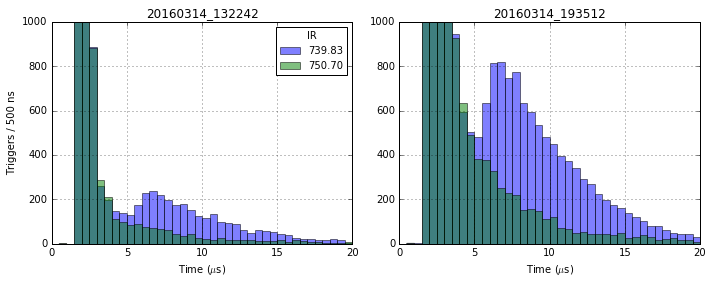

In [4]:
## plot setup
fig, ax = plt.subplots(1, len(RIDS), figsize=(10,4))
bin_width = 0.5
bins=np.arange(0.5,20 + bin_width, bin_width)

max_amp = 0.025
max_width = 0.5e-6

# select data
VIDS = [1, 2]
for i, rid in enumerate(RIDS):
    rdat = allDF.loc[rid]
    for vid in VIDS:
        # select data
        data = rdat[((rdat[uDF.columns] == uDF.loc[vid]).all(1))]
        # cut triggers
        data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
        trigs = (data['trigger'].values)*1e6
        ax[i].hist(trigs, bins=bins, alpha=0.5, label='%.2f'%uDF.loc[vid, 'IR'])
    
#format
plt.axhline(0, color='k', alpha=0.5)
lgd = ax[0].legend(loc=0, fontsize=10, title='IR')
ax[0].set_ylabel("Triggers / 500 ns");
ax[0].set_xlabel(r"Time ($\mu$s)");
ax[0].set_ylim(0,1000)
ax[0].set_title(RIDS[0]);
ax[0].grid(True)

ax[1].set_xlabel(r"Time ($\mu$s)");
ax[1].set_ylim(0,1000)
ax[1].set_title(RIDS[1]);
ax[1].grid(True)


#save data
plt.tight_layout();
fileout = os.path.join(out_dire, "_".join(NAMES) + '_trigger_comp.png')
plt.savefig(fileout, dpi=150)

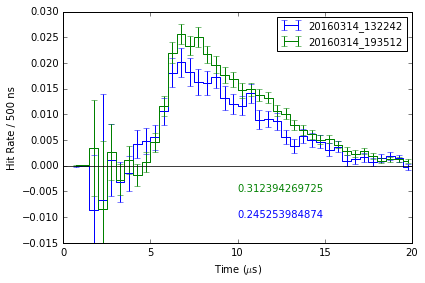

In [5]:
# histogram bins
bin_width = 0.5
bins=np.arange(0.5,20 + bin_width, bin_width)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
for i, rid in enumerate(RIDS):
    rdat = allDF.loc[rid]
    log = logDF.loc[rid]
    # background
    vid_off = 2
    # select data
    data = rdat[(rdat[uDF.columns] == uDF.loc[vid_off]).all(1)]
    acq_off = log.loc[np.unique(data.squid.values), 'ACQUIRE'].sum()
    # cut triggers
    data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
    trigs = (data['trigger'].values)*1e6
    n_off = np.histogram(trigs, bins=bins)
    x = n_off[1][:-1]+bin_width/2
    # data
    VIDS = [1]
    n_rows = len(VIDS)
    #plot setup
    hr = []
    for vid in VIDS:
        # select data
        data = rdat[(rdat[uDF.columns] == uDF.loc[vid]).all(1)]
        acq_on = log.loc[np.unique(data.squid.values), 'ACQUIRE'].sum()
        # cut triggers
        data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
        trigs = (data['trigger'].values)*1e6
        n_on = np.histogram(trigs, bins=bins)
        # normalise and subtract background
        y =  np.subtract(n_on[0]/ acq_on, n_off[0] / acq_off)
        yerr  = np.add(np.sqrt(n_on[0])/ acq_on, np.sqrt(n_off[0])/ acq_off)
        ax.errorbar(x, y, yerr=yerr, drawstyle='steps-mid', label=rid)
        ax.legend(loc=0, fontsize=10)
        ax.set_ylabel("Hit Rate / 500 ns")
        ax.axhline(0, color='k', alpha=0.5)
        ax.text(10, [-0.01, -0.005][i],y[5:].sum(), color=['b', 'g'][i])
        hr.append(y[4:].sum())

# format
ax.set_xlabel(r"Time ($\mu$s)");
ax.set_ylim(-0.015, 0.03)
# save data
plt.tight_layout();
fileout = os.path.join(out_dire, "_".join(NAMES) + '_bsub_comp.png')
plt.savefig(fileout, dpi=150)
plt.show()